In [49]:
# Imports
import numpy as np
import pandas as pd
import pickle
from scipy import interpolate
from scipy.special import roots_hermite, h_roots
from tqdm.notebook import tqdm
import math
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib_fontja
import copy
import glob
import os
from collections.abc import Iterable

%load_ext autoreload
%autoreload 2
from tools_v3 import fn_utility, environment_retire, environment_work, make_grid_maliar

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
data = pd.read_pickle("output/save_dict_20250607.pkl")
for key, val in data['parameters'].items():
    globals()[key] = val
print('読み込まれたパラメタ')
print(list(data['parameters'].keys()))

for key, val in data['data'].items():
    globals()[key] = val
print('読み込まれたデータ')
print(list(data['data'].keys()))

読み込まれたパラメタ
['t_birth', 't_retire', 't_death', 'n_quad', 'n_alpha', 'n_cons', 'n_cash', 'delta', 'gamma', 'r_f', 'vol_r', 'expr', 'reg_coef', 'rate_insub', 'vol_y_t', 'vol_y_p', 'max_cash', 'min_cash', 'max_cons', 'min_cons', 'maliar_theta', 'w_quad', 'v_quad', 'rate_surv', 'grid_alpha', 'grid_cash', 'grid_cons', 'grid_ret', 'portret', 'coef_labor', 'wage_average', 'wage_retire', 'grid_wage_p']
読み込まれたデータ
['values', 'policy_cons', 'policy_alpha']


In [51]:
def generate_single_worker_wage_path_level(wage_average, vol_y_p, vol_y_t, seed=None, bias_correction=True, shrink_pshock=False):
    """
    1人の労働者の賃金パスを生成する関数（レベルバージョン）
    論文の式: log(Y_it) = f(t, Z_it) + v_it + ε_it
    where v_it = v_{i,t-1} + u_it
    
    Parameters:
    wage_average: 平均賃金プロファイル（年齢別の配列）
    vol_y_p: 永続的ショックの標準偏差
    vol_y_t: 一時的ショックの標準偏差
    seed: 乱数シード（Noneの場合は設定しない）
    bias_correction: バイアス調整を行うかどうか
    
    Returns:
    wage_path: 賃金パス（年齢別）
    ages: 対応する年齢
    """
    if seed is not None:
        np.random.seed(seed)
    
    # 年齢範囲
    ages = np.arange(t_birth, t_retire + 1)
    n_years = len(ages)
    
    # 永続的ショックの生成（各年の変化u_it）
    permanent_shock_changes = np.random.normal(0, vol_y_p, n_years)
    
    # 永続的ショックは前年からの累積 v_it = v_{i,t-1} + u_it
    permanent_shocks = np.zeros(n_years)
    if shrink_pshock:
        multiplier = n_years
    else:
        multiplier = 1
    for t in range(1, n_years):
        permanent_shocks[t] = permanent_shocks[t-1] + permanent_shock_changes[t] / multiplier
        
    # 一時的ショックの生成（各年独立）
    temporary_shocks = np.random.normal(0, vol_y_t, n_years)
    
    # バイアス調整項の計算
    if bias_correction:
        # ログノーマル分布のバイアス調整
        # 永続的ショックのバイアス調整（累積分散を考慮）
        permanent_bias = np.zeros(n_years)
        for t in range(n_years):
            permanent_var = (t + 1) * vol_y_p**2  # t期までの累積分散
            permanent_bias[t] = -0.5 * permanent_var
        
        # 一時的ショックのバイアス調整
        temporary_bias = -0.5 * vol_y_t**2
    else:
        permanent_bias = np.zeros(n_years)
        temporary_bias = 0
    
    # 賃金パスの計算
    # log(wage) = log(平均賃金) + 永続的ショック + 一時的ショック + バイアス調整
    log_wage = (np.log(wage_average) + 
                permanent_shocks + permanent_bias + 
                temporary_shocks + temporary_bias)
    wage_path = np.exp(log_wage)
    
    return wage_path, ages

def generate_single_worker_wage_path_growth(wage_average, vol_y_p, vol_y_t, seed=None, bias_correction=True):
    """
    1人の労働者の賃金パスを生成する関数（成長率バージョン）
    各期の成長率にショックを加える方式
    log(Y_it / Y_{i,t-1}) = g_t + u_it + ε_it - ε_{i,t-1}
    
    Parameters:
    wage_average: 平均賃金プロファイル（年齢別の配列）
    vol_y_p: 永続的ショック（成長率への影響）の標準偏差
    vol_y_t: 一時的ショック（成長率への影響）の標準偏差
    seed: 乱数シード（Noneの場合は設定しない）
    bias_correction: バイアス調整を行うかどうか
    
    Returns:
    wage_path: 賃金パス（年齢別）
    ages: 対応する年齢
    """
    if seed is not None:
        np.random.seed(seed)
    
    # 年齢範囲
    ages = np.arange(t_birth, t_retire + 1)
    n_years = len(ages)
    
    # 平均賃金から成長率を計算
    growth_rates = np.zeros(n_years)
    growth_rates[0] = 0  # 初期値
    for t in range(1, n_years):
        growth_rates[t] = np.log(wage_average[t]) - np.log(wage_average[t-1])
    
    # 永続的ショック（成長率への影響）
    permanent_growth_shocks = np.random.normal(0, vol_y_p, n_years)
    
    # 賃金のショックの蓄積が大きすぎるので追加
    if notARwage:
        permanent_shocks = permanent_shock_changes
    # 一時的ショック（成長率への影響）
    temporary_growth_shocks = np.random.normal(0, vol_y_t, n_years)
    
    # バイアス調整項
    if bias_correction:
        # 成長率ベースのバイアス調整
        permanent_bias = -0.5 * vol_y_p**2
        temporary_bias = -0.5 * vol_y_t**2
    else:
        permanent_bias = 0
        temporary_bias = 0
    
    # 賃金パスの計算
    wage_path = np.zeros(n_years)
    wage_path[0] = wage_average[0] * np.exp(temporary_growth_shocks[0] + temporary_bias)  # 初期値
    
    for t in range(1, n_years):
        # 成長率 = 平均成長率 + 永続的ショック + 一時的ショック - 前期の一時的ショック + バイアス調整
        actual_growth = (growth_rates[t] + 
                        permanent_growth_shocks[t] + permanent_bias +
                        temporary_growth_shocks[t] + temporary_bias - 
                        (temporary_growth_shocks[t-1] + temporary_bias))
        
        wage_path[t] = wage_path[t-1] * np.exp(actual_growth)
    
    return wage_path, ages

In [52]:

def plot_simulation_results(df_wage, wage_average, n_simulations=10000):
    """
    シミュレーション結果をプロットする関数
    
    Parameters:
    df_wage: シミュレーション結果（DataFrame）
    wage_average: 平均賃金プロファイル
    n_simulations: シミュレーション回数
    """
    ages = df_wage.index.values
    
    # 統計量の計算
    mean_wages = df_wage.mean(axis=1)
    std_wages = df_wage.std(axis=1)
    percentile_5 = df_wage.quantile(0.05, axis=1)
    percentile_95 = df_wage.quantile(0.95, axis=1)
    percentile_25 = df_wage.quantile(0.25, axis=1)
    percentile_75 = df_wage.quantile(0.75, axis=1)
    
    # 2x2のサブプロット
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. メイン統計プロット
    ax1 = axes[0, 0]
    ax1.fill_between(ages, percentile_5, percentile_95, alpha=0.2, color='blue', label='5th-95th Percentile')
    ax1.fill_between(ages, percentile_25, percentile_75, alpha=0.3, color='blue', label='25th-75th Percentile')
    ax1.plot(ages, mean_wages, 'b-', linewidth=2, label='Simulated Mean')
    ax1.plot(ages, wage_average, 'k--', linewidth=2, label='Theoretical Mean')
    ax1.set_title(f'Wage Distribution\n(n={n_simulations:,} simulations)')
    ax1.set_xlabel('Age')
    ax1.set_ylabel('Wage')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. 標準偏差の推移
    ax2 = axes[0, 1]
    ax2.plot(ages, std_wages, 'r-', linewidth=2, label='Standard Deviation')
    ax2.plot(ages, std_wages/mean_wages, 'g-', linewidth=2, label='Coefficient of Variation')
    ax2.set_title('Variability over Age')
    ax2.set_xlabel('Age')
    ax2.set_ylabel('Standard Deviation / CV')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. 個別サンプルの表示（10本）
    ax3 = axes[1, 0]
    for i in range(10):
        ax3.plot(ages, df_wage.iloc[:, i], alpha=0.6, linewidth=1)
    ax3.plot(ages, wage_average, 'k--', linewidth=3, label='Average Wage')
    ax3.set_title('Sample Paths (10 individuals)')
    ax3.set_xlabel('Age')
    ax3.set_ylabel('Wage')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. 年齢別分布（ヒストグラム、特定年齢）
    ax4 = axes[1, 1]
    selected_ages = [25, 35, 45, 55, 65]  # 特定の年齢
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    
    for i, age in enumerate(selected_ages):
        if age in ages:
            age_idx = list(ages).index(age)
            ax4.hist(df_wage.iloc[age_idx], bins=50, alpha=0.3, 
                    color=colors[i], label=f'Age {age}', density=True)
    
    ax4.set_title('Wage Distribution by Age')
    ax4.set_xlabel('Wage')
    ax4.set_ylabel('Density')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 統計サマリーの表示
    print("=== 統計サマリー ===")
    print(f"シミュレーション回数: {n_simulations:,}")
    print(f"平均賃金（最終年齢）: {mean_wages.iloc[-1]:.2f}")
    print(f"標準偏差（最終年齢）: {std_wages.iloc[-1]:.2f}")
    print(f"変動係数（最終年齢）: {std_wages.iloc[-1]/mean_wages.iloc[-1]:.3f}")
    print(f"5%パーセンタイル（最終年齢）: {percentile_5.iloc[-1]:.2f}")
    print(f"95%パーセンタイル（最終年齢）: {percentile_95.iloc[-1]:.2f}")

In [53]:
wage_list = []
wage_list_x = []
for i in range(5000):
    #wage_path, ages = generate_single_worker_wage_path_growth(wage_average, vol_y_p, vol_y_t)
    wage_path, ages = generate_single_worker_wage_path_level(wage_average, vol_y_p, vol_y_t,bias_correction=False,shrink_pshock=True)
    wage_list.append(wage_path)
    # wage_list_x.append(wage_path_x)
    

df_wage = pd.DataFrame(columns=ages, index= [f"sample{j+1}" for j in range(len(wage_list))], data=wage_list).T

In [54]:
for age in range(t_retire+1, t_death):
    df_wage.loc[age, :] = rate_insub * df_wage.loc[t_retire, :]

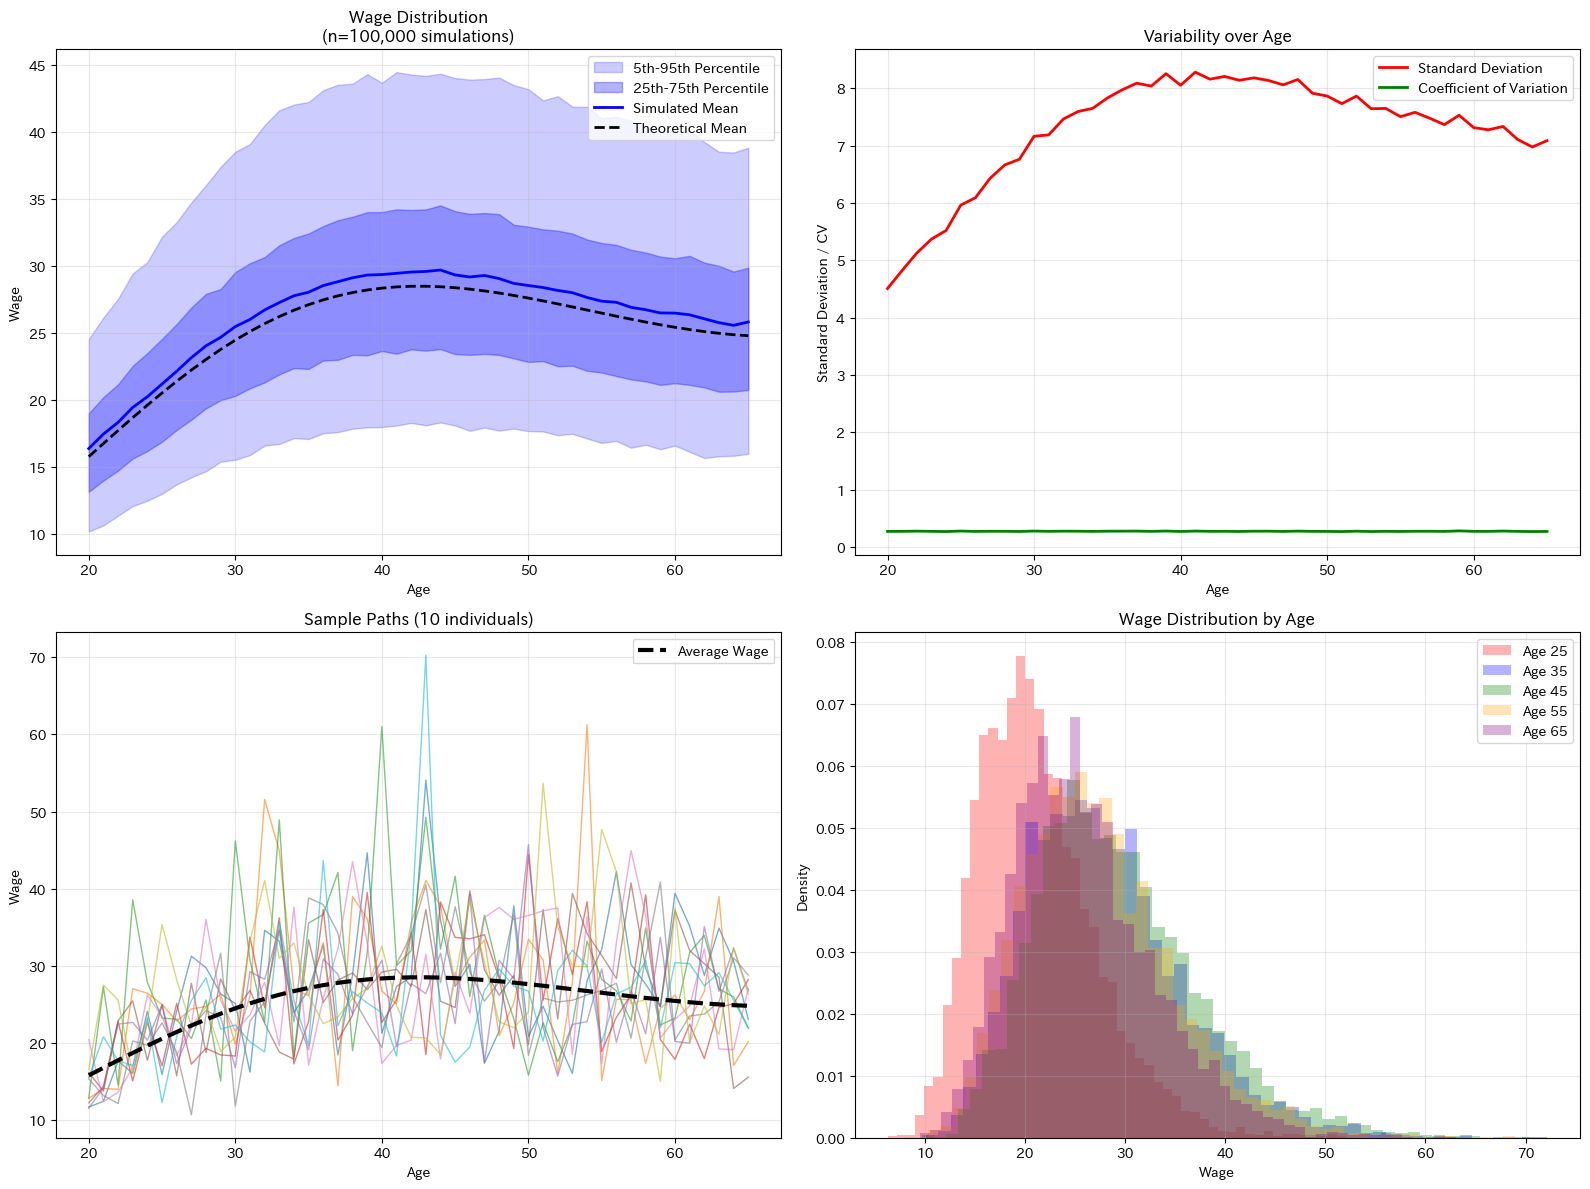

=== 統計サマリー ===
シミュレーション回数: 100,000
平均賃金（最終年齢）: 25.82
標準偏差（最終年齢）: 7.09
変動係数（最終年齢）: 0.274
5%パーセンタイル（最終年齢）: 15.98
95%パーセンタイル（最終年齢）: 38.83


In [55]:
plot_simulation_results(df_wage.loc[:t_retire], wage_average, n_simulations=100000)

In [56]:
print("policy_alpha.shape⇒", policy_alpha.shape)
print("policy_cons.shape ⇒", policy_cons.shape)
fn_policy_alpha_list = list()
fn_policy_cons_list = list()
for t in range(policy_alpha.shape[0]):
    fn_policy_alpha = interpolate.interp1d(grid_cash, 
                                           policy_alpha[t], 
                                           kind='quadratic', 
                                           bounds_error=False,
                                           fill_value=(0.0, 1.0),
                                          )
    fn_policy_alpha_list.append(fn_policy_alpha)

    fn_policy_cons = interpolate.interp1d(grid_cash, 
                                          policy_cons[t], 
                                          kind='quadratic', 
                                          bounds_error=False,
                                          fill_value=(np.min(policy_cons), np.max(policy_cons)),
                                         )
    fn_policy_cons_list.append(fn_policy_cons)

policy_alpha.shape⇒ (80, 1001)
policy_cons.shape ⇒ (80, 1001)


In [57]:
name_people = "sample1"
initial_asset = 2
wage_path = df_wage.loc[:,name_people].to_numpy()
asset_path = np.full(len(wage_path)+1,np.nan) # 死亡する直前まで含むのでwage_pathよりも1つ多い
alpha_path = np.full_like(asset_path,np.nan)
cons_path = np.full_like(asset_path,np.nan)

asset_path[0] = initial_asset
for t in range(policy_cons.shape[0]):
    is_save = np.random.binomial(1, rate_surv[t])
    is_save = 1
    if is_save:
        age = t_birth + t
        cash_in_hand = asset_path[t] + wage_path[t]
        alpha_t = fn_policy_alpha_list[t](cash_in_hand)
        consumption_t = fn_policy_cons_list[t](cash_in_hand)
        alpha_path[t] = alpha_t
        cons_path[t] = consumption_t
        random_return = alpha_t * np.random.normal(expr, vol_r) + (1 - alpha_t) * r_f
        asset_path[t+1] = (1 + random_return) * (cash_in_hand - consumption_t)

In [58]:
simu_result = dict()
simu_result["asset_path"] = dict()
simu_result["alpha_path"] = dict()
simu_result["cons_path"] = dict()

for name_people in tqdm(df_wage.columns):
    initial_asset = 2
    wage_path = df_wage.loc[:,name_people].to_numpy()
    asset_path = np.full(len(wage_path)+1,np.nan) # 死亡する直前まで含むのでwage_pathよりも1つ多い
    alpha_path = np.full_like(asset_path,np.nan)
    cons_path = np.full_like(asset_path,np.nan)
    
    asset_path[0] = initial_asset
    for t in range(policy_cons.shape[0]):
        is_save = np.random.binomial(1, rate_surv[t])
        is_save = 1
        if is_save:
            age = t_birth + t
            cash_in_hand = asset_path[t] + wage_path[t]
            alpha_t = fn_policy_alpha_list[t](cash_in_hand)
            consumption_t = fn_policy_cons_list[t](cash_in_hand)
            alpha_path[t] = alpha_t
            cons_path[t] = consumption_t
            random_return = alpha_t * np.random.normal(expr, vol_r) + (1 - alpha_t) * r_f
            asset_path[t+1] = (1 + random_return) * (cash_in_hand - consumption_t)
    
    simu_result["asset_path"][name_people] = asset_path
    simu_result["alpha_path"][name_people] = alpha_path
    simu_result["cons_path"][name_people] = cons_path

  0%|          | 0/5000 [00:00<?, ?it/s]

In [59]:
df_simu_asset = pd.DataFrame(simu_result['asset_path'],index=[i for i in range(t_birth,t_death+1)])
df_simu_alpha = pd.DataFrame(simu_result['alpha_path'],index=[i for i in range(t_birth,t_death+1)])
df_simu_cons = pd.DataFrame(simu_result['cons_path'],index=[i for i in range(t_birth,t_death+1)])

In [60]:
def plot_age_statistics(data_df, 
                       title="Age Statistics", 
                       ylabel="Value", 
                       xlabel="Age",
                       figsize=(10, 6),
                       colors=None,
                       show_std_bands=True,
                       show_percentile_bands=True,
                       percentile_ranges=[(5, 95), (25, 75)],
                       alpha_values=[0.2, 0.3],
                       line_width=2,
                       grid=True,
                       legend_loc='best'):
    """
    年齢別データの統計を可視化する汎用関数
    
    Parameters:
    -----------
    data_df : pd.DataFrame
        データフレーム（index: 年齢, columns: 個体・サンプル）
    title : str
        グラフタイトル
    ylabel : str
        Y軸ラベル
    xlabel : str
        X軸ラベル
    figsize : tuple
        図のサイズ
    colors : dict
        色の指定 {'mean': 'blue', 'std': 'red', 'percentile1': 'blue', 'percentile2': 'blue'}
    show_std_bands : bool
        標準偏差バンドを表示するか
    show_percentile_bands : bool
        パーセンタイルバンドを表示するか
    percentile_ranges : list of tuples
        パーセンタイル範囲のリスト [(下位, 上位), ...]
    alpha_values : list
        各パーセンタイルバンドの透明度
    line_width : int
        線の太さ
    grid : bool
        グリッドを表示するか
    legend_loc : str
        凡例の位置
    
    Returns:
    --------
    fig, ax : matplotlib objects
        図とaxesオブジェクト
    stats_dict : dict
        計算された統計値の辞書
    """
    
    # デフォルト色の設定
    if colors is None:
        colors = {
            'mean': 'blue',
            'std': 'red', 
            'percentile1': 'blue',
            'percentile2': 'blue'
        }
    
    # 統計量の計算
    ages = data_df.index
    mean_values = data_df.mean(axis=1)
    std_values = data_df.std(axis=1)
    
    # パーセンタイルの計算
    percentile_data = {}
    for i, (lower, upper) in enumerate(percentile_ranges):
        percentile_data[f'p{lower}'] = data_df.quantile(lower/100, axis=1)
        percentile_data[f'p{upper}'] = data_df.quantile(upper/100, axis=1)
    
    # プロット作成
    fig, ax = plt.subplots(figsize=figsize)
    
    # パーセンタイルバンドの描画
    if show_percentile_bands:
        for i, (lower, upper) in enumerate(percentile_ranges):
            alpha = alpha_values[i] if i < len(alpha_values) else 0.3
            color_key = f'percentile{i+1}' if f'percentile{i+1}' in colors else 'percentile1'
            
            ax.fill_between(
                ages, 
                percentile_data[f'p{lower}'], 
                percentile_data[f'p{upper}'],
                alpha=alpha, 
                color=colors[color_key],
                label=f'{lower}th-{upper}th Percentile'
            )
    
    # 平均線の描画
    ax.plot(ages, mean_values, color=colors['mean'], 
            linewidth=line_width, label='Mean')
    
    # 標準偏差バンドの描画
    if show_std_bands:
        ax.plot(ages, mean_values + std_values, '--', 
                color=colors['std'], linewidth=1, alpha=0.7, 
                label='Mean ± 1 Std')
        ax.plot(ages, mean_values - std_values, '--', 
                color=colors['std'], linewidth=1, alpha=0.7)
    
    # グラフの装飾
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend(loc=legend_loc)
    
    if grid:
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # 統計情報の辞書
    stats_dict = {
        'ages': ages,
        'mean': mean_values,
        'std': std_values,
        'percentiles': percentile_data,
        'global_stats': {
            'overall_mean': data_df.values.mean(),
            'overall_std': data_df.values.std(),
            'max_value': data_df.values.max(),
            'min_value': data_df.values.min()
        }
    }
    
    return fig, ax, stats_dict

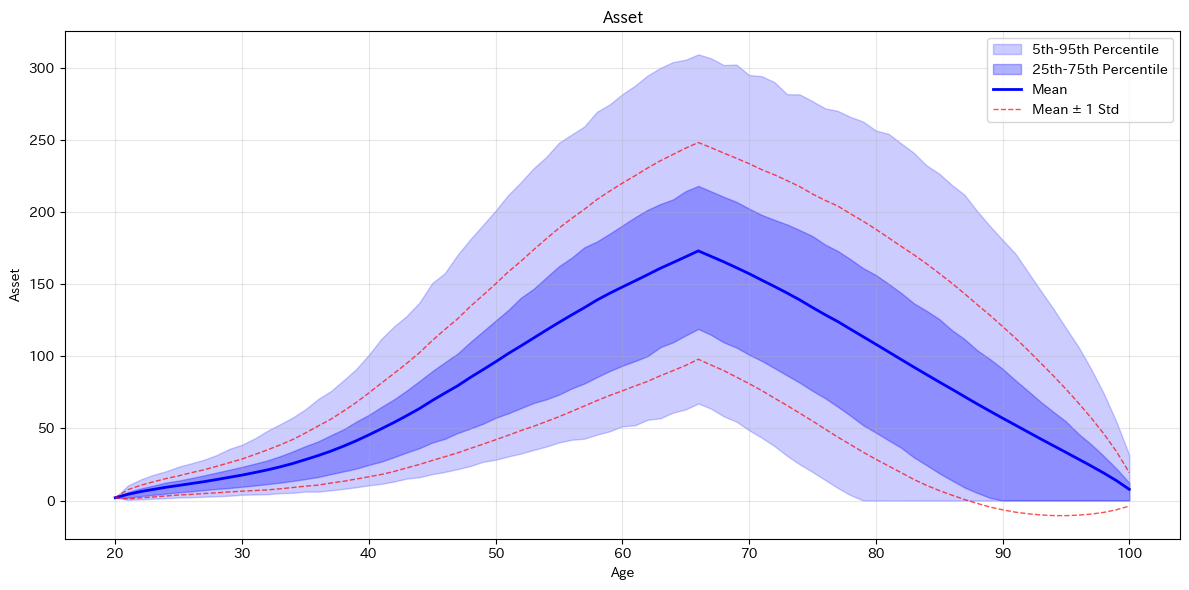

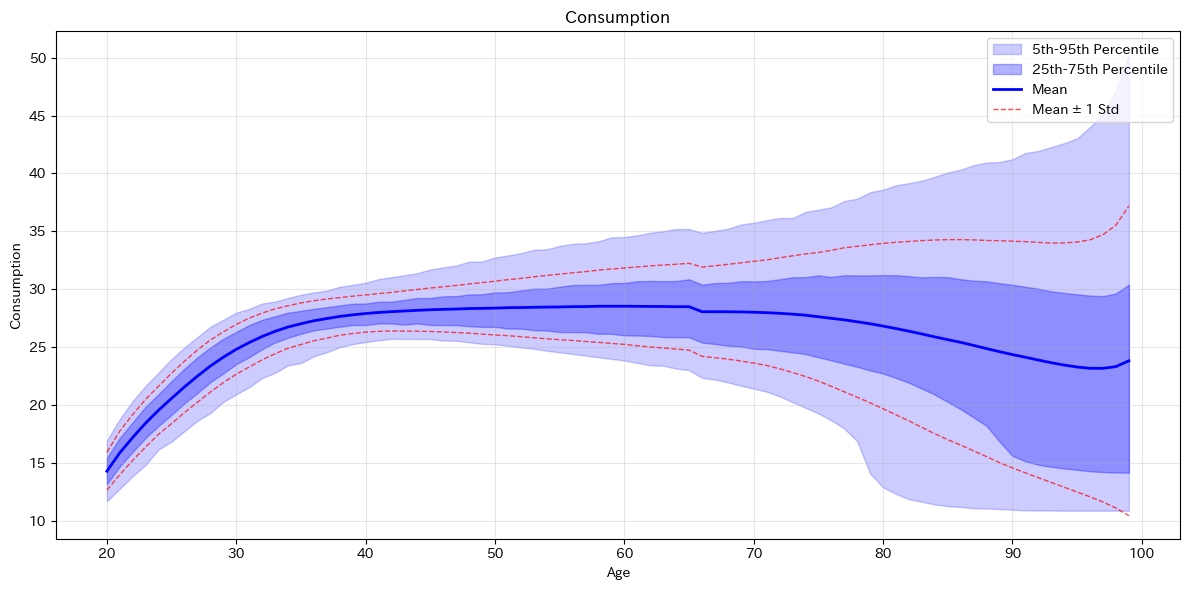

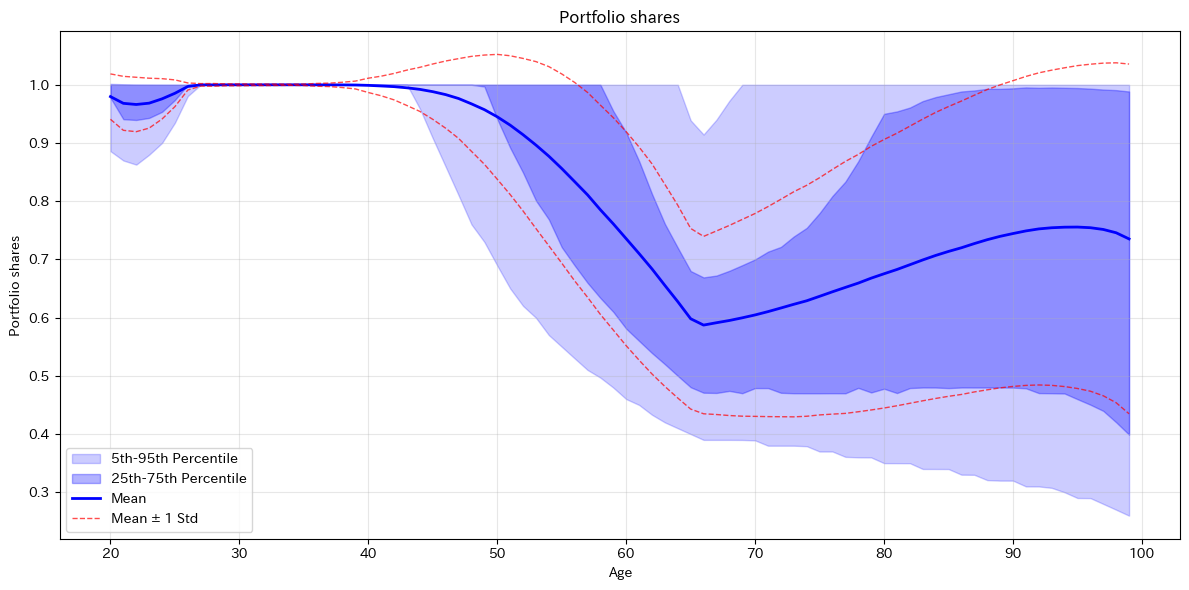

In [61]:
_,_, stats_asset = plot_age_statistics(df_simu_asset, title="Asset", ylabel="Asset", figsize=(12, 6))
#pd.DataFrame(stats_asset)
plt.show()
_,_, stats_cons = plot_age_statistics(df_simu_cons, title="Consumption", ylabel="Consumption", figsize=(12, 6))
plt.show()
_,_, stats_alpha = plot_age_statistics(df_simu_alpha, title="Portfolio shares", ylabel="Portfolio shares", figsize=(12, 6))
plt.show()

80


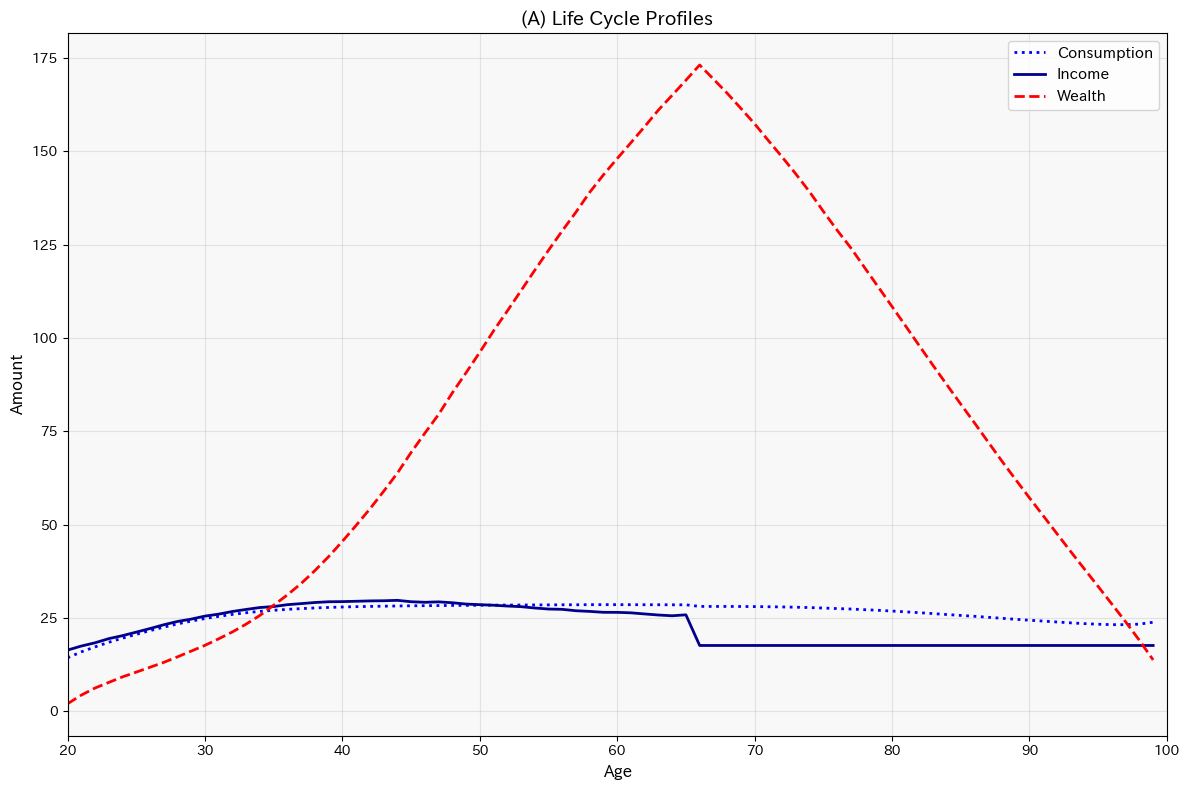

In [69]:
# データの準備
ages = [i for i in range(t_birth, t_death)]
print(len(ages))
wage_mean = df_wage.mean(axis=1)
asset_mean = df_simu_asset.loc[ages].mean(axis=1)
cons_mean = df_simu_cons.loc[ages].mean(axis=1)

# グラフの作成
plt.figure(figsize=(12, 8))

# 線の描画
plt.plot(ages, cons_mean, ':', linewidth=2, color='blue', label='Consumption')
plt.plot(ages, wage_mean, '-', linewidth=2, color='darkblue', label='Income')
plt.plot(ages, asset_mean, '--', linewidth=2, color='red', label='Wealth')

# グラフの装飾
plt.xlabel('Age', fontsize=12)
plt.ylabel('Amount', fontsize=12)
plt.title('(A) Life Cycle Profiles', fontsize=14, fontweight='bold')
plt.legend(loc='upper right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.xlim(20, 100)

# 背景色を軽くグレーに
plt.gca().set_facecolor('#f8f8f8')

plt.tight_layout()
plt.show()

In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_age_asset_heatmap(ages, assets, values, title, cmap='viridis', ax=None):
    """年齢×資産のヒートマップ（ax指定可能に修正）"""
    if ax is None:
        plt.figure(figsize=(12, 8))
        ax = plt.gca()
    
    X, Y = np.meshgrid(assets, ages)
    im = ax.contourf(X, Y, values, levels=20, cmap=cmap)
    plt.colorbar(im, ax=ax, shrink=0.8)
    ax.set_xlabel('Asset (Cash-on-hand)')
    ax.set_ylabel('Age')
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    
    if ax is None:
        plt.show()

def plot_dual_axis_age(ages, left_data, right_data, left_label, right_label, title, ax=None):
    """年齢別データの左右軸プロット（ax指定可能に修正）"""
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
        show_plot = True
    else:
        show_plot = False
    
    # 左軸
    line1 = ax.plot(ages, left_data, 'b-', linewidth=2, label=left_label)
    ax.set_xlabel('Age')
    ax.set_ylabel(left_label, color='b')
    ax.tick_params(axis='y', labelcolor='b')
    ax.grid(True, alpha=0.3)
    
    # 右軸
    ax2 = ax.twinx()
    line2 = ax2.plot(ages, right_data, 'r-', linewidth=2, label=right_label)
    ax2.set_ylabel(right_label, color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    
    ax.set_title(title)
    
    # 凡例
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax.legend(lines, labels, loc='best')
    
    if show_plot:
        plt.tight_layout()
        plt.show()

def plot_combined_policy_analysis(ages, grid_cash, policy_alpha, policy_cons, figsize=(16, 12)):
    """既存の関数を使って4つのプロットを統合"""
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    
    # ①投資比率ヒートマップ（左上）
    plot_age_asset_heatmap(ages, grid_cash, policy_alpha, 'Investment Ratio', 'Blues', ax=axes[0,0])
    
    # ②消費額ヒートマップ（右上）
    plot_age_asset_heatmap(ages, grid_cash, policy_cons, 'Consumption', 'Reds', ax=axes[0,1])
    
    # ③消費割合ヒートマップ（左下）
    consumption_ratio = policy_cons[:,1:] / grid_cash[1:]
    plot_age_asset_heatmap(ages, grid_cash[1:], consumption_ratio, 'Consumption Ratio', 'Greens', ax=axes[1,0])
    
    # ④年齢別平均（左右軸）（右下）
    avg_investment = policy_alpha.mean(axis=1)
    avg_consumption = policy_cons.mean(axis=1)
    plot_dual_axis_age(ages, avg_investment, avg_consumption, 
                       'Avg Investment Ratio', 'Avg Consumption', 'Life Cycle Profiles', ax=axes[1,1])
    
    plt.tight_layout()
    plt.show()

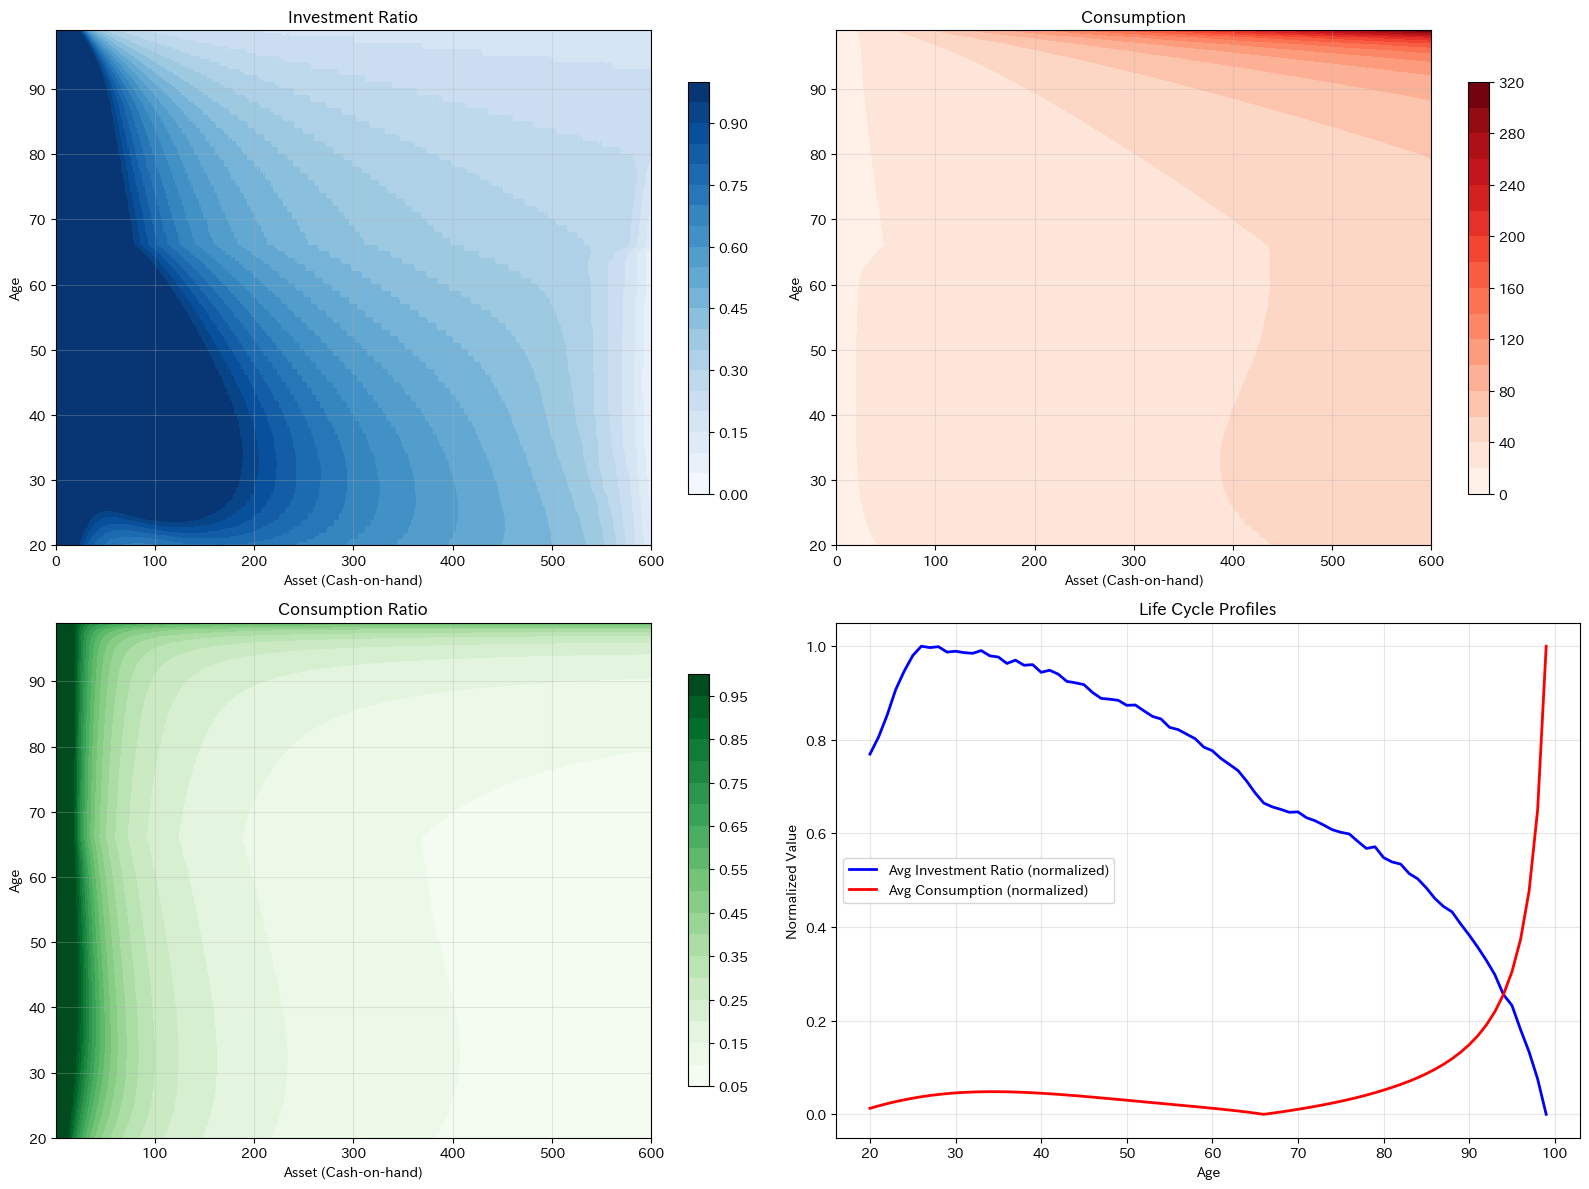

In [95]:
ages = [i for i in range(t_birth, t_death)]
plot_combined_policy_analysis(ages, grid_cash, policy_alpha, policy_cons)